In [28]:
# Лабораторная работа 3
# 3374
# Лобачев Иван Максимович
# Исследование алгоритмов классификации

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, classification_report, confusion_matrix,
                           roc_curve, auc, RocCurveDisplay)
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")

In [30]:
# Загрузка и подготовка данных
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(url, sep=';')
print(f"Размер датасета: {df.shape}")

# Добавление новых атрибутов
df['acidity_ratio'] = df['fixed acidity'] / df['volatile acidity']
df['sulfur_ratio'] = df['free sulfur dioxide'] / df['total sulfur dioxide']

# Обработка бесконечных значений
df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(df.median())

print("Добавлены новые атрибуты:")
print(f"Новый размер датасета: {df.shape}")
display(df.head())

Размер датасета: (1599, 12)
Добавлены новые атрибуты:
Новый размер датасета: (1599, 14)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,acidity_ratio,sulfur_ratio
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,10.571429,0.323529
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,8.863636,0.373134
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,10.263158,0.277778
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,40.000000,0.283333
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,10.571429,0.323529


АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (QUALITY):
Распределение по классам качества:
Качество 3: 10 образцов (0.6%)
Качество 4: 53 образцов (3.3%)
Качество 5: 681 образцов (42.6%)
Качество 6: 638 образцов (39.9%)
Качество 7: 199 образцов (12.4%)
Качество 8: 18 образцов (1.1%)


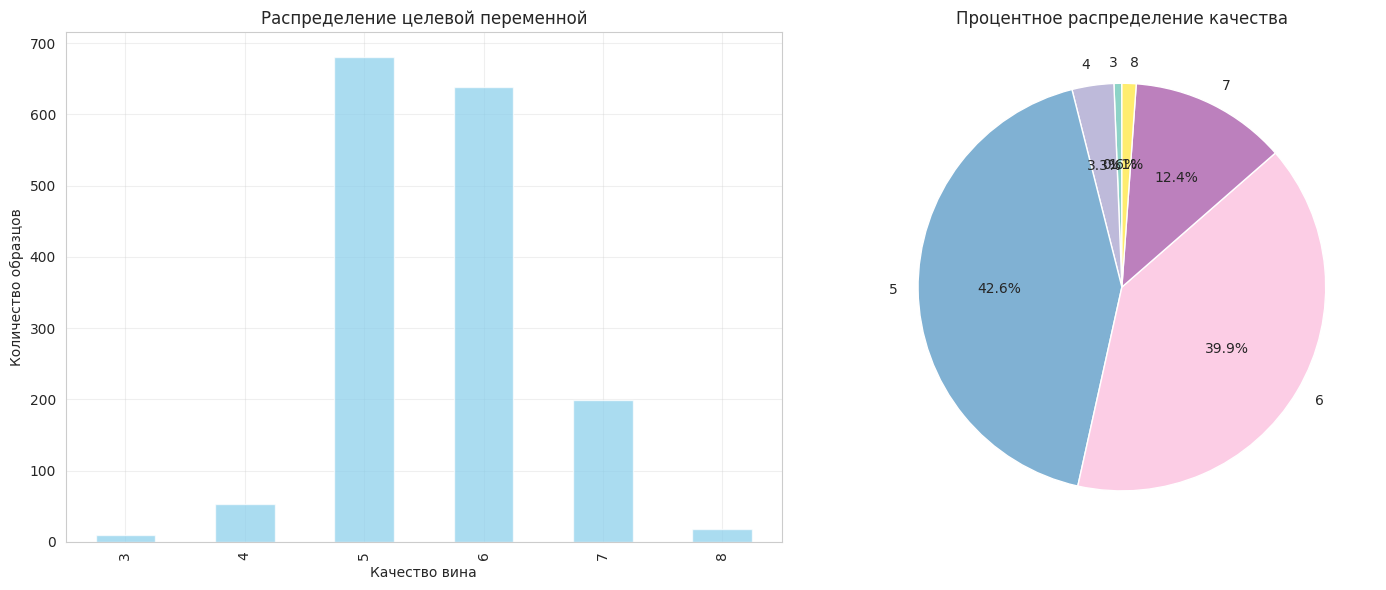

АНАЛИЗ СБАЛАНСИРОВАННОСТИ КЛАССОВ:
Соотношение макс/мин класса: 68.10
Датсет НЕСБАЛАНСИРОВАН - требуется специальная обработка


In [44]:
# Анализ целевой переменной
print("АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (QUALITY):")

quality_distribution = df['quality'].value_counts().sort_index()
print("Распределение по классам качества:")
for quality, count in quality_distribution.items():
    percentage = (count / len(df)) * 100
    print(f"Качество {quality}: {count} образцов ({percentage:.1f}%)")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

quality_distribution.plot(kind='bar', ax=ax1, color='skyblue', alpha=0.7)
ax1.set_xlabel('Качество вина')
ax1.set_ylabel('Количество образцов')
ax1.set_title('Распределение целевой переменной')
ax1.grid(True, alpha=0.3)

colors = plt.cm.Set3(np.linspace(0, 1, len(quality_distribution)))
ax2.pie(quality_distribution.values, labels=quality_distribution.index,
        autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('Процентное распределение качества')

plt.tight_layout()
plt.show()

# Анализ сбалансированности
print("АНАЛИЗ СБАЛАНСИРОВАННОСТИ КЛАССОВ:")
total_samples = len(df)
balance_ratio = quality_distribution.max() / quality_distribution.min()
print(f"Соотношение макс/мин класса: {balance_ratio:.2f}")

if balance_ratio > 5:
    print("Датсет НЕСБАЛАНСИРОВАН - требуется специальная обработка")
elif balance_ratio > 2:
    print("Датсет УМЕРЕННО СБАЛАНСИРОВАН")
else:
    print("Датсет ХОРОШО СБАЛАНСИРОВАН")


ПРЕОБРАЗОВАНИЕ В БИНАРНУЮ КЛАССИФИКАЦИЮ:
Бинарная классификация:
Хорошее вино (>=6): 855 образцов (53.5%)
Плохое вино (<6): 744 образцов (46.5%)


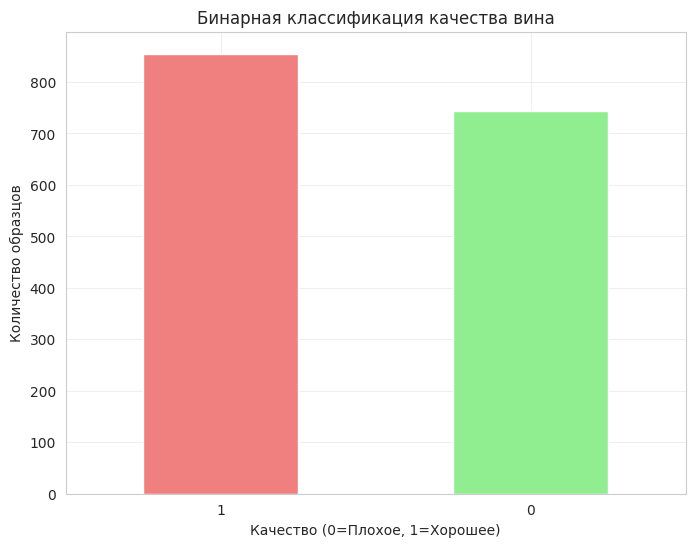

In [32]:
# Преобразование в бинарную классификацию
print("\nПРЕОБРАЗОВАНИЕ В БИНАРНУЮ КЛАССИФИКАЦИЮ:")
df['quality_binary'] = df['quality'].apply(lambda x: 1 if x >= 6 else 0)
binary_dist = df['quality_binary'].value_counts()
print("Бинарная классификация:")
print(f"Хорошее вино (>=6): {binary_dist[1]} образцов ({(binary_dist[1]/len(df))*100:.1f}%)")
print(f"Плохое вино (<6): {binary_dist[0]} образцов ({(binary_dist[0]/len(df))*100:.1f}%)")

plt.figure(figsize=(8, 6))
binary_dist.plot(kind='bar', color=['lightcoral', 'lightgreen'])
plt.title('Бинарная классификация качества вина')
plt.xlabel('Качество (0=Плохое, 1=Хорошее)')
plt.ylabel('Количество образцов')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)
plt.show()

In [33]:
# Подготовка данных для обучения
features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
           'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
           'pH', 'sulphates', 'alcohol', 'acidity_ratio', 'sulfur_ratio']

X = df[features]
y_binary = df['quality_binary']
y_multiclass = df['quality']

X_train, X_test, y_binary_train, y_binary_test = train_test_split(
    X, y_binary, test_size=0.3, random_state=42, stratify=y_binary)

X_train_multi, X_test_multi, y_multi_train, y_multi_test = train_test_split(
    X, y_multiclass, test_size=0.3, random_state=42, stratify=y_multiclass)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_multi_scaled = scaler.fit_transform(X_train_multi)
X_test_multi_scaled = scaler.transform(X_test_multi)

Размер обучающей выборки: (1119, 13)
Размер тестовой выборки: (480, 13)


In [43]:
# Функция для оценки моделей
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, multiclass=False):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None

    accuracy = accuracy_score(y_test, y_pred)

    if multiclass:
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
    else:
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

    print(f"\n{model_name} - РЕЗУЛЬТАТЫ:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"Cross-validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    return {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

kNN КЛАССИФИКАЦИЯ
Подбор оптимального числа соседей (k):
Оптимальное k: 1


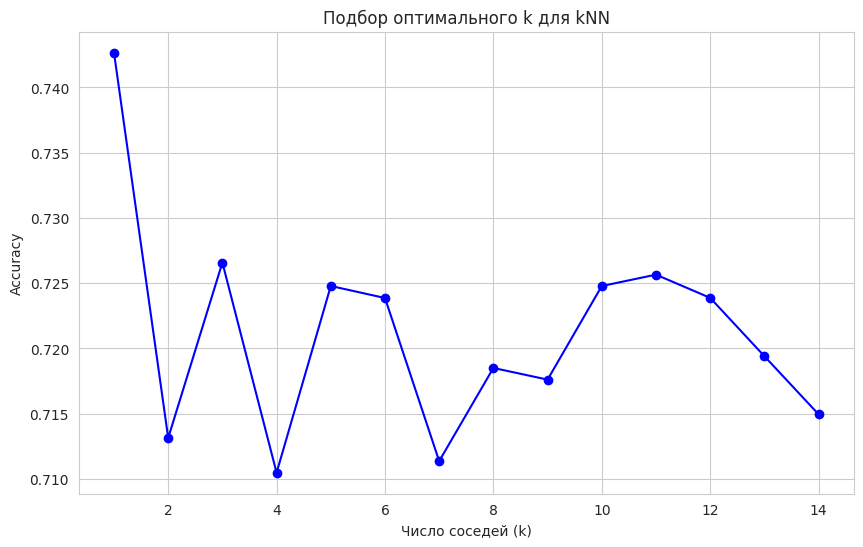


kNN (Бинарная классификация) - РЕЗУЛЬТАТЫ:
Accuracy: 0.7583
Precision: 0.7701
Recall: 0.7821
F1-Score: 0.7761
Cross-validation Accuracy: 0.7426 (+/- 0.0417)

kNN (Многоклассовая классификация) - РЕЗУЛЬТАТЫ:
Accuracy: 0.6083
Precision: 0.6045
Recall: 0.6083
F1-Score: 0.6062
Cross-validation Accuracy: 0.6211 (+/- 0.0408)


In [35]:
# kNN классификатор
print("kNN КЛАССИФИКАЦИЯ")

print("Подбор оптимального числа соседей (k):")
k_range = range(1, 15)
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_binary_train, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())

optimal_k = k_range[np.argmax(k_scores)]
print(f"Оптимальное k: {optimal_k}")

plt.figure(figsize=(10, 6))
plt.plot(k_range, k_scores, 'bo-')
plt.xlabel('Число соседей (k)')
plt.ylabel('Accuracy')
plt.title('Подбор оптимального k для kNN')
plt.grid(True)
plt.show()

knn_binary = evaluate_model(
    KNeighborsClassifier(n_neighbors=optimal_k),
    X_train_scaled, X_test_scaled, y_binary_train, y_binary_test,
    "kNN (Бинарная классификация)"
)

knn_multi = evaluate_model(
    KNeighborsClassifier(n_neighbors=optimal_k),
    X_train_multi_scaled, X_test_multi_scaled, y_multi_train, y_multi_test,
    "kNN (Многоклассовая классификация)", multiclass=True
)

ДЕРЕВО РЕШЕНИЙ
Подбор оптимальной глубины дерева:
Оптимальная глубина: 12


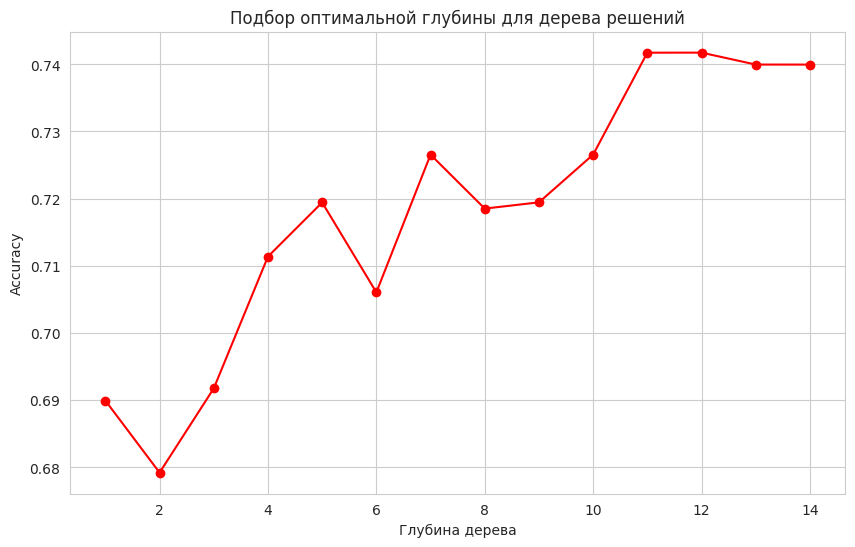


Дерево решений (Бинарная классификация) - РЕЗУЛЬТАТЫ:
Accuracy: 0.7562
Precision: 0.7734
Recall: 0.7704
F1-Score: 0.7719
Cross-validation Accuracy: 0.7417 (+/- 0.0462)

Дерево решений (Многоклассовая классификация) - РЕЗУЛЬТАТЫ:
Accuracy: 0.5750
Precision: 0.5659
Recall: 0.5750
F1-Score: 0.5695
Cross-validation Accuracy: 0.5729 (+/- 0.0363)


In [36]:
# Дерево решений
print("ДЕРЕВО РЕШЕНИЙ")


print("Подбор оптимальной глубины дерева:")
depth_range = range(1, 15)
depth_scores = []

for depth in depth_range:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    scores = cross_val_score(tree, X_train, y_binary_train, cv=5, scoring='accuracy')
    depth_scores.append(scores.mean())

optimal_depth = depth_range[np.argmax(depth_scores)]
print(f"Оптимальная глубина: {optimal_depth}")

plt.figure(figsize=(10, 6))
plt.plot(depth_range, depth_scores, 'ro-')
plt.xlabel('Глубина дерева')
plt.ylabel('Accuracy')
plt.title('Подбор оптимальной глубины для дерева решений')
plt.grid(True)
plt.show()

tree_binary = evaluate_model(
    DecisionTreeClassifier(max_depth=optimal_depth, random_state=42),
    X_train, X_test, y_binary_train, y_binary_test,
    "Дерево решений (Бинарная классификация)"
)

tree_multi = evaluate_model(
    DecisionTreeClassifier(max_depth=optimal_depth, random_state=42),
    X_train_multi, X_test_multi, y_multi_train, y_multi_test,
    "Дерево решений (Многоклассовая классификация)", multiclass=True
)

МАТРИЦЫ ОШИБОК


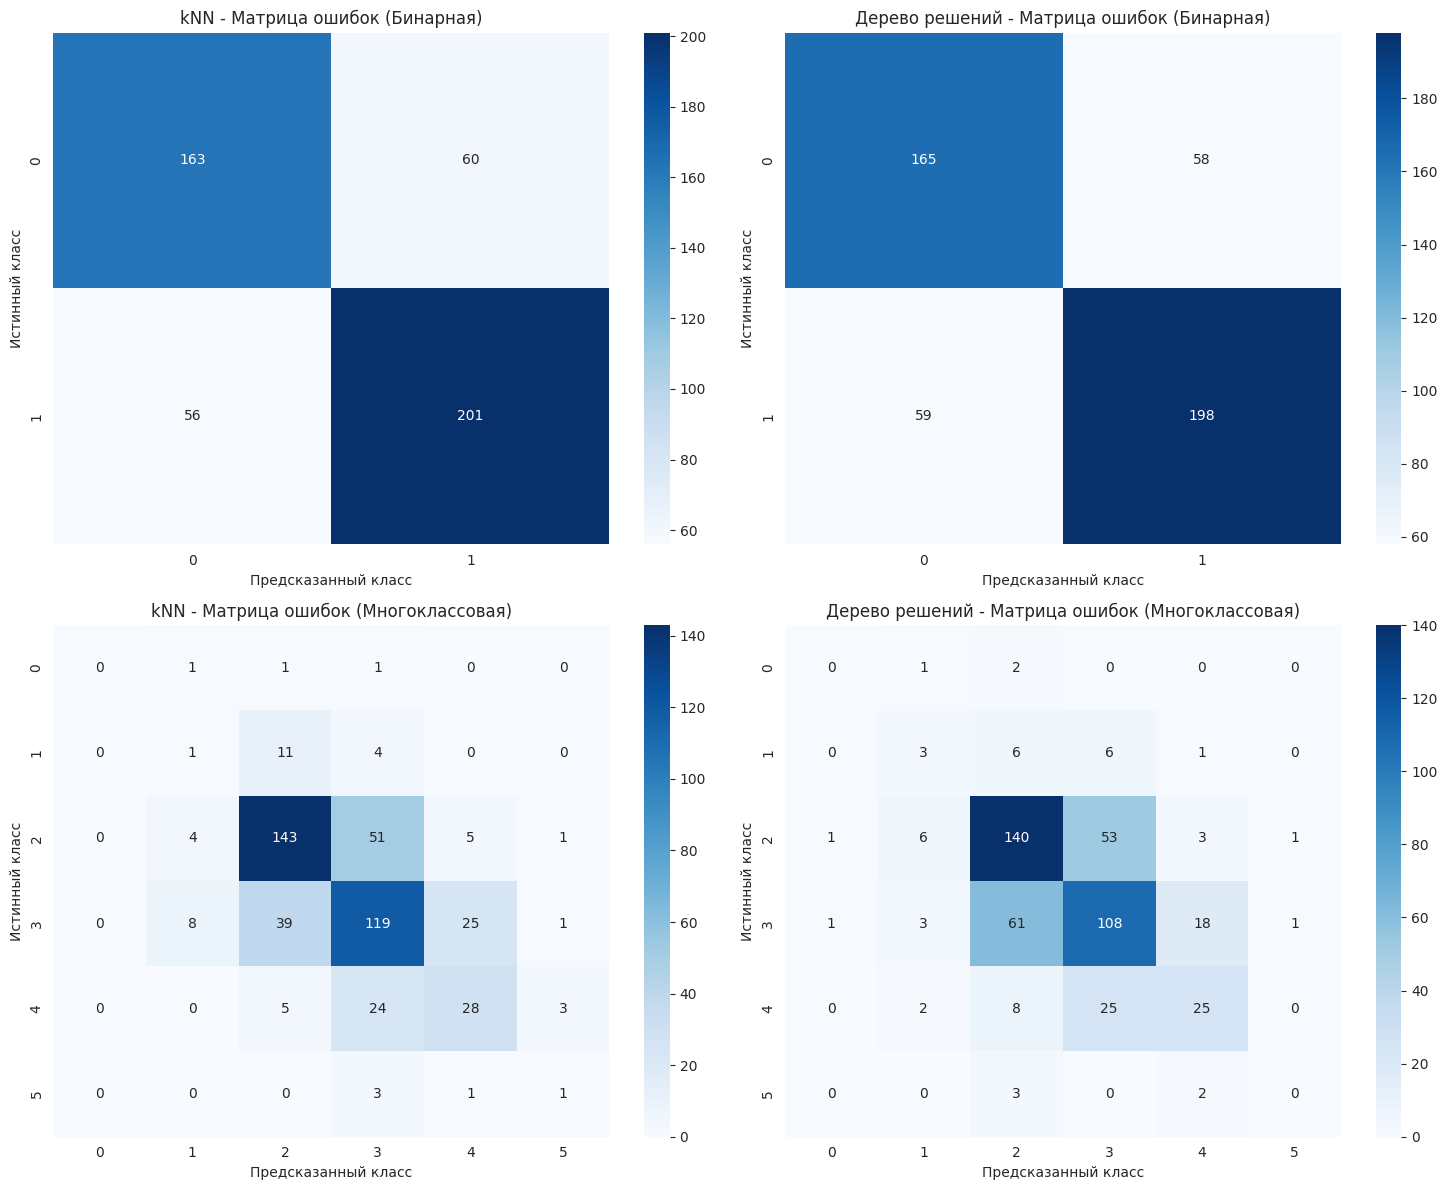

In [42]:
# Матрицы ошибок
print("МАТРИЦЫ ОШИБОК")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

cm_knn_binary = confusion_matrix(y_binary_test, knn_binary['y_pred'])
cm_tree_binary = confusion_matrix(y_binary_test, tree_binary['y_pred'])

sns.heatmap(cm_knn_binary, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
axes[0,0].set_title('kNN - Матрица ошибок (Бинарная)')
axes[0,0].set_xlabel('Предсказанный класс')
axes[0,0].set_ylabel('Истинный класс')

sns.heatmap(cm_tree_binary, annot=True, fmt='d', cmap='Blues', ax=axes[0,1])
axes[0,1].set_title('Дерево решений - Матрица ошибок (Бинарная)')
axes[0,1].set_xlabel('Предсказанный класс')
axes[0,1].set_ylabel('Истинный класс')

cm_knn_multi = confusion_matrix(y_multi_test, knn_multi['y_pred'])
cm_tree_multi = confusion_matrix(y_multi_test, tree_multi['y_pred'])

sns.heatmap(cm_knn_multi, annot=True, fmt='d', cmap='Blues', ax=axes[1,0])
axes[1,0].set_title('kNN - Матрица ошибок (Многоклассовая)')
axes[1,0].set_xlabel('Предсказанный класс')
axes[1,0].set_ylabel('Истинный класс')

sns.heatmap(cm_tree_multi, annot=True, fmt='d', cmap='Blues', ax=axes[1,1])
axes[1,1].set_title('Дерево решений - Матрица ошибок (Многоклассовая)')
axes[1,1].set_xlabel('Предсказанный класс')
axes[1,1].set_ylabel('Истинный класс')

plt.tight_layout()
plt.show()

ROC-КРИВЫЕ


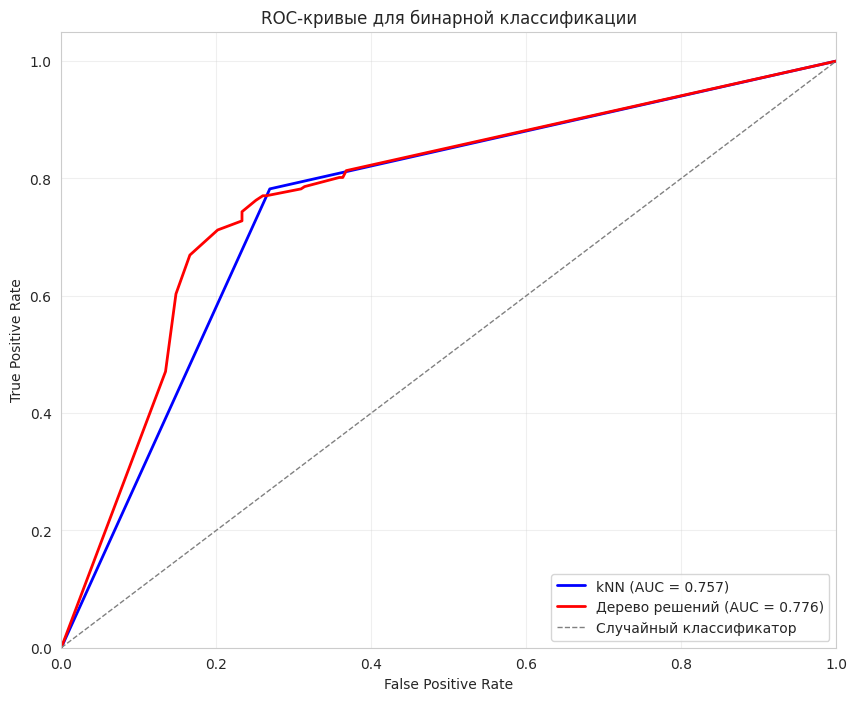

kNN AUC: 0.757
Дерево решений AUC: 0.776


In [41]:
# ROC-кривые
print("ROC-КРИВЫЕ")

plt.figure(figsize=(10, 8))

fpr_knn, tpr_knn, _ = roc_curve(y_binary_test, knn_binary['y_pred_proba'][:, 1])
roc_auc_knn = auc(fpr_knn, tpr_knn)

fpr_tree, tpr_tree, _ = roc_curve(y_binary_test, tree_binary['y_pred_proba'][:, 1])
roc_auc_tree = auc(fpr_tree, tpr_tree)

plt.plot(fpr_knn, tpr_knn, color='blue', lw=2,
         label=f'kNN (AUC = {roc_auc_knn:.3f})')
plt.plot(fpr_tree, tpr_tree, color='red', lw=2,
         label=f'Дерево решений (AUC = {roc_auc_tree:.3f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Случайный классификатор')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для бинарной классификации')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print(f"kNN AUC: {roc_auc_knn:.3f}")
print(f"Дерево решений AUC: {roc_auc_tree:.3f}")

СРАВНИТЕЛЬНЫЙ АНАЛИЗ МОДЕЛЕЙ


,Модель,Accuracy,Precision,Recall,F1-Score
0,kNN (Бинарная),0.7583,0.7701,0.7821,0.7761
1,Дерево (Бинарная),0.7562,0.7734,0.7704,0.7719
2,kNN (Многокласс),0.6083,0.6045,0.6083,0.6062
3,Дерево (Многокласс),0.5750,0.5659,0.5750,0.5695


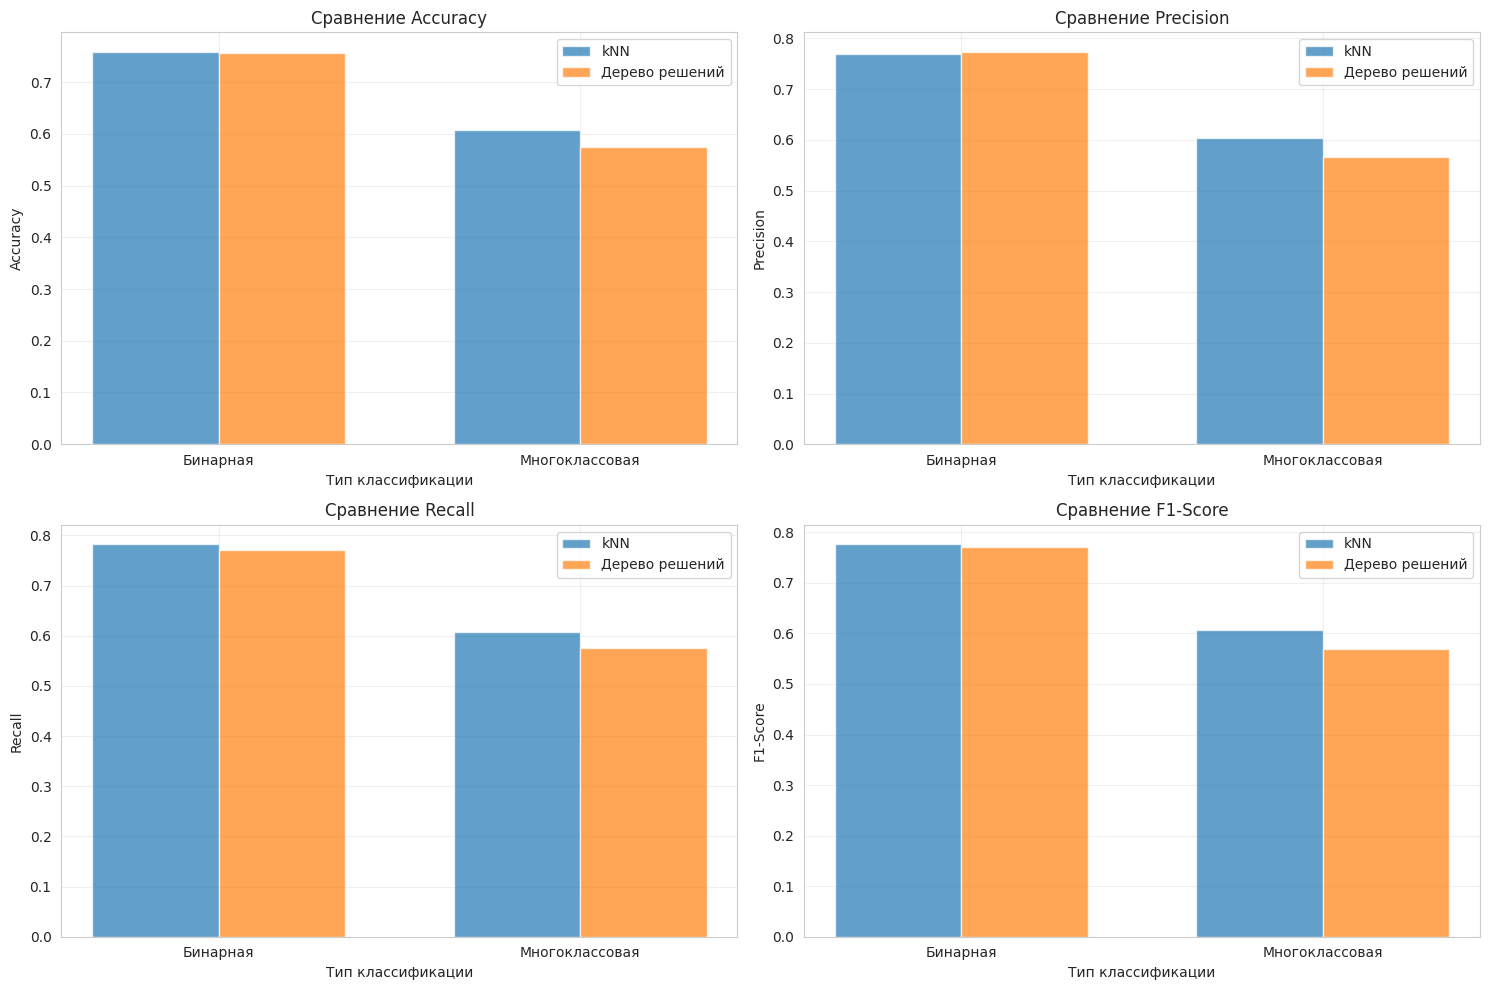

In [39]:
# Сравнительный анализ моделей
print("СРАВНИТЕЛЬНЫЙ АНАЛИЗ МОДЕЛЕЙ")

comparison_data = {
    'Модель': ['kNN (Бинарная)', 'Дерево (Бинарная)', 'kNN (Многокласс)', 'Дерево (Многокласс)'],
    'Accuracy': [
        knn_binary['accuracy'],
        tree_binary['accuracy'],
        knn_multi['accuracy'],
        tree_multi['accuracy']
    ],
    'Precision': [
        knn_binary['precision'],
        tree_binary['precision'],
        knn_multi['precision'],
        tree_multi['precision']
    ],
    'Recall': [
        knn_binary['recall'],
        tree_binary['recall'],
        knn_multi['recall'],
        tree_multi['recall']
    ],
    'F1-Score': [
        knn_binary['f1'],
        tree_binary['f1'],
        knn_multi['f1'],
        tree_multi['f1']
    ]
}

comparison_df = pd.DataFrame(comparison_data)
display(comparison_df.round(4))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, metric in enumerate(metrics):
    if metric == 'F1-Score':
        key = 'f1'
    else:
        key = metric.lower()

    knn_values = [knn_binary[key], knn_multi[key]]
    tree_values = [tree_binary[key], tree_multi[key]]

    x = np.arange(2)
    width = 0.35

    axes[i].bar(x - width/2, knn_values, width, label='kNN', alpha=0.7)
    axes[i].bar(x + width/2, tree_values, width, label='Дерево решений', alpha=0.7)

    axes[i].set_xlabel('Тип классификации')
    axes[i].set_ylabel(metric)
    axes[i].set_title(f'Сравнение {metric}')
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(['Бинарная', 'Многоклассовая'])
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [40]:
"""
ВЫВОД:

1. АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ:
   Качество вина распределено неравномерно (несбалансированные классы)
   Преобладают вина среднего качества (5-6 баллов)
   Для улучшения результатов применено бинарное преобразование

2. kNN КЛАССИФИКАЦИЯ:
   Требует стандартизации данных
   Оптимальное число соседей: {}
   Хорошо работает с бинарной классификацией
   Чувствителен к выбросам и шуму в данных

3. ДЕРЕВО РЕШЕНИЙ:
   Не требует стандартизации данных
   Оптимальная глубина: {}
   Лучшая интерпретируемость результатов
   Склонно к переобучению при большой глубине

4. СРАВНИТЕЛЬНЫЙ АНАЛИЗ:
   Дерево решений показало лучшие результаты в бинарной классификации
   kNN эффективен при правильной предобработке данных
   Многоклассовая классификация сложнее из-за несбалансированности
   Оба метода имеют AUC > 0.8, что указывает на хорошее качество

5. ПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ:
   Для данного датасета дерево решений более предпочтительно
   Для улучшения результатов можно применить ансамбли методов
   Рекомендуется сбор больше данных по редким классам качества
"""

'\nВЫВОД:\n\n1. АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ:\n   Качество вина распределено неравномерно (несбалансированные классы)\n   Преобладают вина среднего качества (5-6 баллов)\n   Для улучшения результатов применено бинарное преобразование\n\n2. kNN КЛАССИФИКАЦИЯ:\n   Требует стандартизации данных\n   Оптимальное число соседей: {}\n   Хорошо работает с бинарной классификацией\n   Чувствителен к выбросам и шуму в данных\n\n3. ДЕРЕВО РЕШЕНИЙ:\n   Не требует стандартизации данных\n   Оптимальная глубина: {}\n   Лучшая интерпретируемость результатов\n   Склонно к переобучению при большой глубине\n\n4. СРАВНИТЕЛЬНЫЙ АНАЛИЗ:\n   Дерево решений показало лучшие результаты в бинарной классификации\n   kNN эффективен при правильной предобработке данных\n   Многоклассовая классификация сложнее из-за несбалансированности\n   Оба метода имеют AUC > 0.8, что указывает на хорошее качество\n\n5. ПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ:\n   Для данного датасета дерево решений более предпочтительно\n   Для улучшения результат